In [5]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
import fastf1
from scipy.optimize import curve_fit
fastf1.Cache.enable_cache('./f1cache')

In [126]:
session = fastf1.get_session(2022, 'abu dhabi', 'R')
session.load(telemetry=True, laps=True, weather=False)
laps = session.laps
laps.head(0)

core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.2.9]
api            INFO 	Using cached data for driver_info
session     WARNING 	Request for URL http://ergast.com/api/f1/2022/22/results.json failed; using cached response
Traceback (most recent call last):
  File "/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/usr/local/Cellar/python@3.9/3.9.13_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occur

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate


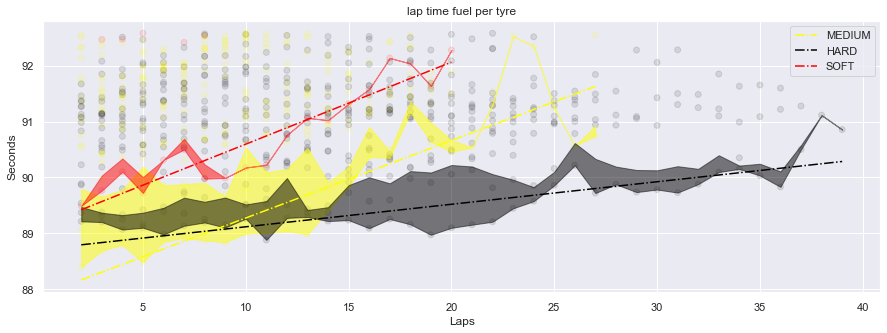

In [8]:
def func(x, a, b):
    return b + x * a

tyreStat_all = laps.set_index("TyreLife")
q_hi  = tyreStat_all["LapTime"].quantile(0.8)
tyreStat = tyreStat_all[(tyreStat_all["LapTime"] < q_hi)]
tyreColor = {
    "MEDIUM": "yellow",
    "HARD": "black",
    "SOFT": "red",
    "INTERMEDIATE": "green",
    "WET": "blue"
}
plt.figure(figsize=(15, 5))
plt.title("lap time fuel per tyre")
plt.xlabel("Laps")
plt.ylabel("Seconds")
plt.scatter(tyreStat.index.values, tyreStat["LapTime"].dt.total_seconds().values, c=tyreStat["Compound"].map(tyreColor).values, alpha=.1)
for tyreCompound in tyreColor:
    comp = tyreStat.query(f"Compound == '{tyreCompound}'").reset_index()
    if len(comp):
        comp_min = comp.groupby("TyreLife")["LapTime"].min().dt.total_seconds()
        comp_01 = comp.groupby("TyreLife")["LapTime"].quantile(.1).dt.total_seconds()

        p0 = [1, 1] # this is an mandatory initial guess
        popt, pcov = curve_fit(func, comp_min.index, comp_min, p0)
        plt.fill_between(
            comp_min.index,
            comp_min,
            comp_01,
            color=tyreColor[tyreCompound],
            alpha=.5
        )
        plt.plot(
            comp_min.index,
            func(comp_min.index, *popt),
            "-.",
            color=tyreColor[tyreCompound],alpha=1,label=tyreCompound
        )
plt.legend()
plt.show()

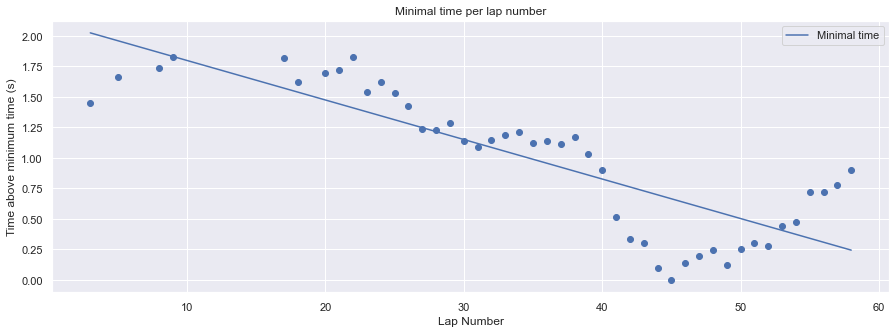

In [12]:
from math import e


def P3(x, a, b, c, d):
    return a + b*x + c*(x ** 2) + d*(x ** 3)

def lin(x, a, b):
    return a + b*x

lapTime = laps.groupby("LapNumber")["LapTime"].quantile(.1).dt.total_seconds()
lapTime = lapTime - lapTime.min()
lapTime = lapTime[(lapTime < lapTime.quantile(0.8))]

p0 = [1, 1] # this is an mandatory initial guess
opt_lapTime, _ = curve_fit(lin, lapTime.index, lapTime, p0)
plt.figure(figsize=(15, 5))
plt.title("Minimal time per lap number")
plt.xlabel("Lap Number")
plt.ylabel("Time above minimum time (s)")
plt.scatter(lapTime.index, lapTime)
plt.plot(
    lapTime.index,
    lin(lapTime.index, *opt_lapTime),
    label="Minimal time"
)
plt.legend()
plt.show()

In [14]:
tyreStat["Corr_LapTime"] = tyreStat.loc[:, "LapTime"].dt.total_seconds() - lin(tyreStat["LapNumber"], *opt_lapTime)

/var/folders/4k/ylc46zj51md5dt2j90r843br0000gn/T/ipykernel_80545/3431998209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tyreStat["Corr_LapTime"] = tyreStat.loc[:, "LapTime"].dt.total_seconds() - lin(tyreStat["LapNumber"], *opt_lapTime)


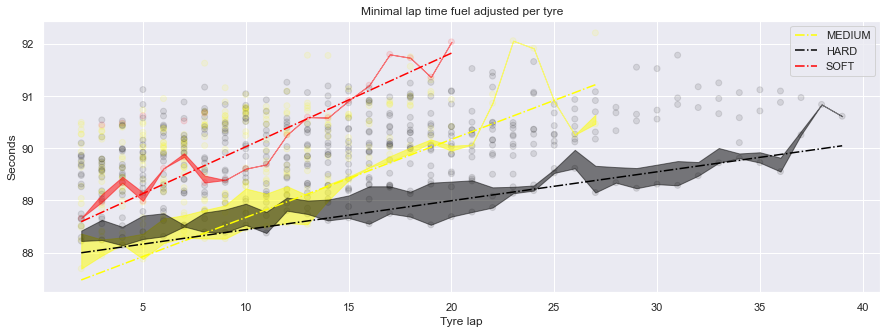

In [15]:
plt.figure(figsize=(15, 5))
plt.title("Minimal lap time fuel adjusted per tyre")
plt.xlabel("Tyre lap")
plt.ylabel("Seconds")
plt.scatter(tyreStat.index.values, tyreStat["Corr_LapTime"].values, c=tyreStat["Compound"].map(tyreColor).values, alpha=.1)
for tyreCompound in tyreColor:
    comp = tyreStat.query(f"Compound == '{tyreCompound}'").reset_index()
    if len(comp):
        comp_min = comp.groupby("TyreLife")["Corr_LapTime"].min()
        comp_01 = comp.groupby("TyreLife")["Corr_LapTime"].quantile(.1)

        p0 = [1, 1] # this is an mandatory initial guess
        popt, pcov = curve_fit(func, comp_min.index, comp_min, p0)
        plt.fill_between(
            comp_min.index,
            comp_min,
            comp_01,
            color=tyreColor[tyreCompound],
            alpha=.5
        )
        plt.plot(
            comp_min.index,
            func(comp_min.index, *popt),
            "-.",
            color=tyreColor[tyreCompound],
            alpha=1,
            label=tyreCompound
        )
plt.legend()
plt.show()

/var/folders/4k/ylc46zj51md5dt2j90r843br0000gn/T/ipykernel_80545/2789880287.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tyreStat["LapTime_s"] = tyreStat["LapTime"].dt.total_seconds()


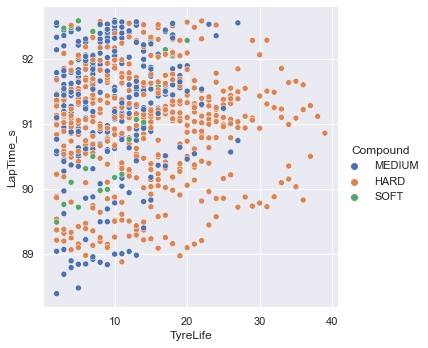

In [16]:
def func(x, a, b):
    return b + x * a

tyreStat_all = laps.set_index("TyreLife")
q_hi  = tyreStat_all["LapTime"].quantile(0.8)
tyreStat = tyreStat_all[(tyreStat_all["LapTime"] < q_hi)]
tyreStat["LapTime_s"] = tyreStat["LapTime"].dt.total_seconds()
tyreColor = {
    "MEDIUM": "yellow",
    "HARD": "black",
    "SOFT": "red",
    "INTERMEDIATE": "green",
    "WET": "blue"
}
sns.relplot(
    data = tyreStat,
    x=tyreStat.index,
    y="LapTime_s",
    hue="Compound",
)

In [17]:
amount_laps_per_driver = laps.groupby("Driver")["LapNumber"].max()
for driver in laps["Driver"].unique():
    laps.loc[laps["Driver"] == driver,:]

In [39]:
laps = session.laps

In [19]:
laps

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,LapTime_avg,LapTime_rel
0,0 days 01:03:42.621000,1,NaT,1,1,0 days 00:22:37.624000,NaT,NaT,0 days 00:00:38.449000,0 days 00:00:33.249000,NaT,0 days 01:03:09.454000,0 days 01:03:42.693000,283.0,286.0,210.0,301.0,False,MEDIUM,1.0,True,0 days 01:02:10.161000,Red Bull Racing,VER,1,False,2022-11-20 13:03:11.207,90.791621,NaN
1,0 days 01:05:13.162000,1,0 days 00:01:30.541000,2,1,NaT,NaT,0 days 00:00:18.571000,0 days 00:00:38.647000,0 days 00:00:33.323000,0 days 01:04:01.192000,0 days 01:04:39.839000,0 days 01:05:13.162000,279.0,288.0,211.0,295.0,False,MEDIUM,2.0,True,0 days 01:03:42.621000,Red Bull Racing,VER,1,True,2022-11-20 13:04:43.667,90.791621,-0.250621
2,0 days 01:06:43.130000,1,0 days 00:01:29.968000,3,1,NaT,NaT,0 days 00:00:18.562000,0 days 00:00:38.526000,0 days 00:00:32.880000,0 days 01:05:31.724000,0 days 01:06:10.250000,0 days 01:06:43.130000,NaN,293.0,211.0,297.0,False,MEDIUM,3.0,True,0 days 01:05:13.162000,Red Bull Racing,VER,1,True,2022-11-20 13:06:14.208,90.791621,-0.823621
3,0 days 01:08:13.498000,1,0 days 00:01:30.368000,4,1,NaT,NaT,0 days 00:00:18.512000,0 days 00:00:38.573000,0 days 00:00:33.283000,0 days 01:07:01.642000,0 days 01:07:40.215000,0 days 01:08:13.498000,280.0,289.0,211.0,295.0,False,MEDIUM,4.0,True,0 days 01:06:43.130000,Red Bull Racing,VER,1,True,2022-11-20 13:07:44.176,90.791621,-0.423621
4,0 days 01:09:44,1,0 days 00:01:30.502000,5,1,NaT,NaT,0 days 00:00:18.492000,0 days 00:00:38.754000,0 days 00:00:33.256000,0 days 01:08:31.990000,0 days 01:09:10.744000,0 days 01:09:44,NaN,289.0,210.0,295.0,False,MEDIUM,5.0,True,0 days 01:08:13.498000,Red Bull Racing,VER,1,True,2022-11-20 13:09:14.544,90.791621,-0.289621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0 days 01:37:58.484000,14,0 days 00:01:31.819000,23,2,NaT,NaT,0 days 00:00:18.373000,0 days 00:00:38.859000,0 days 00:00:34.587000,0 days 01:36:45.038000,0 days 01:37:23.897000,0 days 01:37:58.484000,286.0,299.0,211.0,328.0,False,HARD,4.0,True,0 days 01:36:26.665000,Alpine,ALO,1,True,2022-11-20 13:37:27.711,NaN,NaN
1113,0 days 01:39:29.063000,14,0 days 00:01:30.579000,24,2,NaT,NaT,0 days 00:00:18.351000,0 days 00:00:38.485000,0 days 00:00:33.743000,0 days 01:38:16.835000,0 days 01:38:55.320000,0 days 01:39:29.063000,282.0,309.0,210.0,328.0,True,HARD,5.0,True,0 days 01:37:58.484000,Alpine,ALO,1,True,2022-11-20 13:38:59.530,NaN,NaN
1114,0 days 01:41:00.128000,14,0 days 00:01:31.065000,25,2,NaT,NaT,0 days 00:00:18.337000,0 days 00:00:39.215000,0 days 00:00:33.513000,0 days 01:39:47.400000,0 days 01:40:26.615000,0 days 01:41:00.128000,277.0,291.0,210.0,294.0,False,HARD,6.0,True,0 days 01:39:29.063000,Alpine,ALO,1,True,2022-11-20 13:40:30.109,NaN,NaN
1115,0 days 01:42:30.816000,14,0 days 00:01:30.688000,26,2,NaT,NaT,0 days 00:00:18.295000,0 days 00:00:39.038000,0 days 00:00:33.355000,0 days 01:41:18.423000,0 days 01:41:57.461000,0 days 01:42:30.816000,280.0,293.0,211.0,295.0,False,HARD,7.0,True,0 days 01:41:00.128000,Alpine,ALO,1,True,2022-11-20 13:42:01.174,NaN,NaN


In [26]:
average_lap_per_driver

DriverNumber
1     90.791621
10          NaN
11    90.965638
14          NaN
16    90.942845
18    92.118017
20          NaN
22    92.332500
23          NaN
24          NaN
3     92.227276
31    91.778517
4     91.761172
44          NaN
47          NaN
5     92.238138
55    91.220793
6           NaN
63    91.410379
77          NaN
dtype: float64

In [124]:
session.load_telemetry()

/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/fastf1/core.py:1139: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data


TypeError: Concatenation operation is not implemented for NumPy arrays, use np.concatenate() instead. Please do not rely on this error; it may not be given on all Python implementations.

In [22]:
lec_tele = session.laps.pick_driver("LEC").get_telemetry()

In [23]:
lap = 3

lec_tele["Time_s"] = lec_tele["SessionTime"].dt.total_seconds()
start = session.laps.pick_driver("LEC").query(f"LapNumber == {lap}")["LapStartTime"].dt.total_seconds().values[0]
finish = session.laps.pick_driver("LEC").query(f"LapNumber == {lap+1}")["LapStartTime"].dt.total_seconds().values[0]

lec_lap_tele = lec_tele.query(f"Time_s > {start} and Time_s < {finish}").set_index("Time")

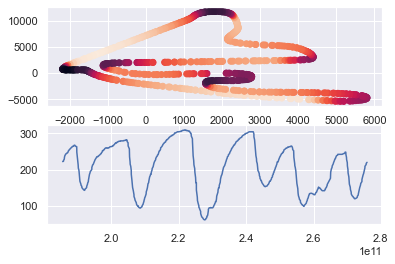

In [24]:
plt.figure()
plt.subplot(2,1,1)
plt.scatter(lec_lap_tele.X, lec_lap_tele.Y, c=lec_lap_tele.Speed)
plt.subplot(2,1,2)
plt.plot(lec_lap_tele.Speed)
plt.show()

/Users/jroga/Documents/f1 stats/f1thon/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


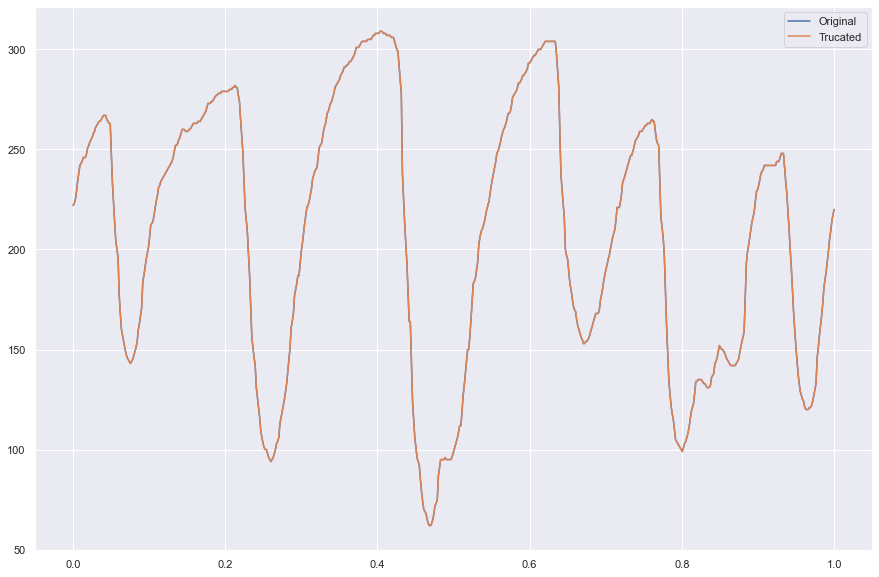

In [25]:
from scipy.fft import fft, ifft, fftfreq

speed = lec_lap_tele.Speed.resample("1ms").ffill().values


fft_speed = fft(speed)
xfft_speed = fftfreq(len(speed), speed)
plt.figure(figsize=(15, 10))
plt.plot(np.linspace(0, 1, len(lec_lap_tele.Speed)), lec_lap_tele.Speed, label="Original")
new_speed = ifft(fft(lec_lap_tele.Speed))
plt.plot(np.linspace(0, 1, len(new_speed)), new_speed, label="Trucated")
plt.legend()
plt.show()

In [128]:
# Removing car performance.
laps = session.laps
laps["LapTime_s"] = laps["LapTime"].dt.total_seconds()
driver_avg_LapTime = laps.groupby("DriverNumber").min()["LapTime_s"].rename("LapTime_s_min")
laps = laps.join(driver_avg_LapTime, on="DriverNumber")
laps["LapTime_s_rel"] = laps["LapTime_s"] - laps["LapTime_s_min"]
laps

AttributeError: Can only use .dt accessor with datetimelike values

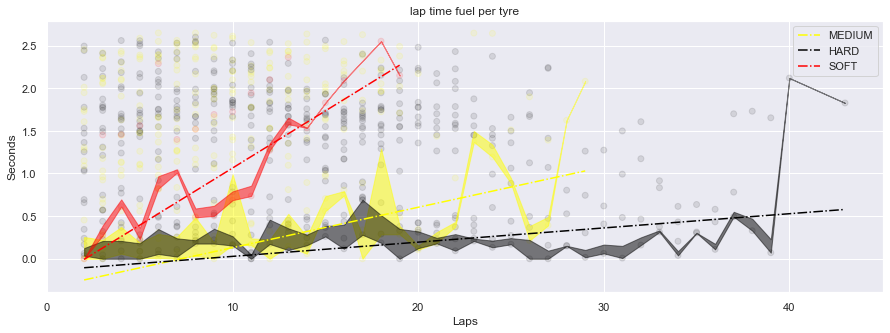

In [81]:
def func(x, a, b):
    return b + x * a

tyreStat_all = laps.set_index("TyreLife")
q_hi  = tyreStat_all["LapTime_s_rel"].quantile(0.8)
tyreStat = tyreStat_all[(tyreStat_all["LapTime_s_rel"] < q_hi)]
tyreColor = {
    "MEDIUM": "yellow",
    "HARD": "black",
    "SOFT": "red",
    "INTERMEDIATE": "green",
    "WET": "blue"
}
plt.figure(figsize=(15, 5))
plt.title("lap time fuel per tyre")
plt.xlabel("Laps")
plt.ylabel("Seconds")
plt.scatter(tyreStat.index.values, tyreStat["LapTime_s_rel"].values, c=tyreStat["Compound"].map(tyreColor).values, alpha=.1)
for tyreCompound in tyreColor:
    comp = tyreStat.query(f"Compound == '{tyreCompound}'").reset_index()
    if len(comp):
        comp_min = comp.groupby("TyreLife")["LapTime_s_rel"].min()
        comp_01 = comp.groupby("TyreLife")["LapTime_s_rel"].quantile(.1)

        p0 = [1, 1] # this is an mandatory initial guess
        popt, pcov = curve_fit(func, comp_min.index, comp_min, p0)
        plt.fill_between(
            comp_min.index,
            comp_min,
            comp_01,
            color=tyreColor[tyreCompound],
            alpha=.5
        )
        plt.plot(
            comp_min.index,
            func(comp_min.index, *popt),
            "-.",
            color=tyreColor[tyreCompound],alpha=1,label=tyreCompound
        )
plt.legend()
plt.show()

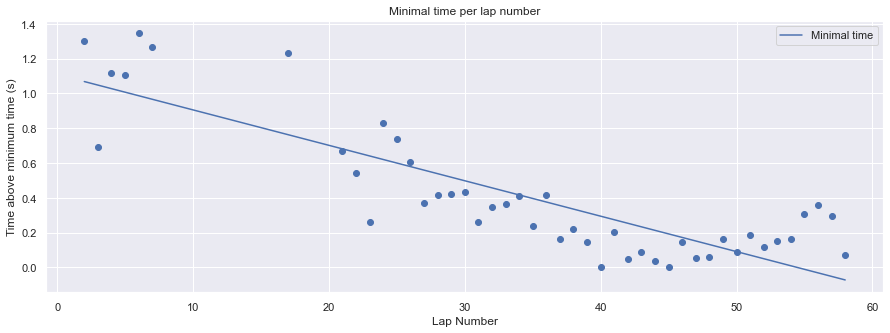

In [82]:
from math import e


def P3(x, a, b, c, d):
    return a + b*x + c*(x ** 2) + d*(x ** 3)

def lin(x, a, b):
    return a + b*x

lapTime = laps.groupby("LapNumber")["LapTime_s_rel"].quantile(.1)
lapTime = lapTime - lapTime.min()
lapTime = lapTime[(lapTime < lapTime.quantile(0.8))]

p0 = [1, 1] # this is an mandatory initial guess
opt_lapTime, _ = curve_fit(lin, lapTime.index, lapTime, p0)
plt.figure(figsize=(15, 5))
plt.title("Minimal time per lap number")
plt.xlabel("Lap Number")
plt.ylabel("Time above minimum time (s)")
plt.scatter(lapTime.index, lapTime)
plt.plot(
    lapTime.index,
    lin(lapTime.index, *opt_lapTime),
    label="Minimal time"
)
plt.legend()
plt.show()

In [83]:
tyreStat["Corr_LapTime"] = tyreStat.loc[:, "LapTime_s_rel"] - lin(tyreStat["LapNumber"], *opt_lapTime)

/var/folders/4k/ylc46zj51md5dt2j90r843br0000gn/T/ipykernel_80545/4278767307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tyreStat["Corr_LapTime"] = tyreStat.loc[:, "LapTime_s_rel"] - lin(tyreStat["LapNumber"], *opt_lapTime)


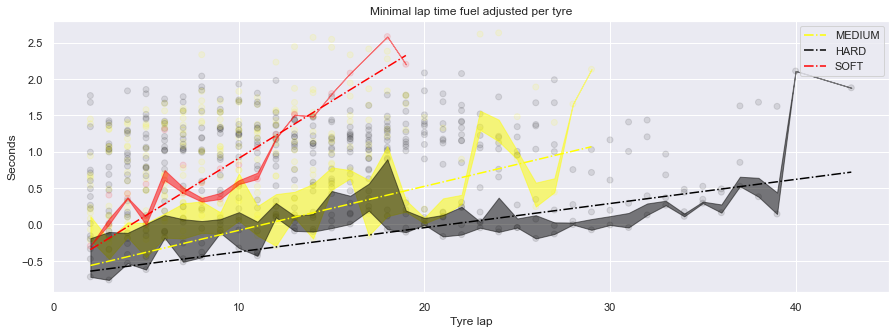

In [85]:
plt.figure(figsize=(15, 5))
plt.title("Minimal lap time fuel adjusted per tyre")
plt.xlabel("Tyre lap")
plt.ylabel("Seconds")
plt.scatter(tyreStat.index.values, tyreStat["Corr_LapTime"].values, c=tyreStat["Compound"].map(tyreColor).values, alpha=.1)
for tyreCompound in tyreColor:
    comp = tyreStat.query(f"Compound == '{tyreCompound}'").reset_index()
    if len(comp):
        comp_min = comp.groupby("TyreLife")["Corr_LapTime"].min()
        comp_01 = comp.groupby("TyreLife")["Corr_LapTime"].quantile(.2)

        p0 = [1, 1] # this is an mandatory initial guess
        popt, pcov = curve_fit(func, comp_min.index, comp_min, p0)
        plt.fill_between(
            comp_min.index,
            comp_min,
            comp_01,
            color=tyreColor[tyreCompound],
            alpha=.5
        )
        plt.plot(
            comp_min.index,
            func(comp_min.index, *popt),
            "-.",
            color=tyreColor[tyreCompound],
            alpha=1,
            label=tyreCompound
        )
plt.legend()
plt.show()

In [127]:
laps = session.laps
laps["PitOutTime"] = laps["PitOutTime"].dt.total_seconds()
laps["PitInTime"] = laps["PitInTime"].dt.total_seconds()
laps.loc[
    (laps["PitOutTime"].isna()) |
    (laps["PitInTime"].isna())
] = 0
laps["PitInTime_shifted"] = laps.groupby("Driver")["PitInTime"].shift(1)
laps["PitStopTime"] = (
    laps["PitOutTime"] - laps["PitInTime_shifted"]
)
laps.loc[laps["LapNumber"] == 1, "PitStopTime"] = 0


per = laps.query("Driver == 'PER' and PitStopTime == 0")
lec = laps.query("Driver == 'LEC' and PitStopTime == 0")

plt.scatter(lec["LapNumber"], lec["LapTime_s"], label="Leclerc")
plt.scatter(per["LapNumber"], per["LapTime_s"], label="Perez")
plt.legend()

KeyError: 'LapTime_s'

In [122]:
laps

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,Sector1SessionTime,Sector2SessionTime,Sector3SessionTime,SpeedI1,SpeedI2,SpeedFL,SpeedST,IsPersonalBest,Compound,TyreLife,FreshTyre,LapStartTime,Team,Driver,TrackStatus,IsAccurate,LapStartDate,LapTime_s,PitInTime_shifted,PitStopTime
0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0,0,0,0,0,0,0.000,NaN,NaN
1,0 days 01:05:13.162000,1,0 days 00:01:30.541000,2,1,NaN,NaN,0 days 00:00:18.571000,0 days 00:00:38.647000,0 days 00:00:33.323000,0 days 01:04:01.192000,0 days 01:04:39.839000,0 days 01:05:13.162000,279.0,288.0,211.0,295.0,False,MEDIUM,2.0,True,0 days 01:03:42.621000,Red Bull Racing,VER,1,True,2022-11-20 13:04:43.667000,90.541,NaN,NaN
2,0 days 01:06:43.130000,1,0 days 00:01:29.968000,3,1,NaN,NaN,0 days 00:00:18.562000,0 days 00:00:38.526000,0 days 00:00:32.880000,0 days 01:05:31.724000,0 days 01:06:10.250000,0 days 01:06:43.130000,NaN,293.0,211.0,297.0,False,MEDIUM,3.0,True,0 days 01:05:13.162000,Red Bull Racing,VER,1,True,2022-11-20 13:06:14.208000,89.968,NaN,NaN
3,0 days 01:08:13.498000,1,0 days 00:01:30.368000,4,1,NaN,NaN,0 days 00:00:18.512000,0 days 00:00:38.573000,0 days 00:00:33.283000,0 days 01:07:01.642000,0 days 01:07:40.215000,0 days 01:08:13.498000,280.0,289.0,211.0,295.0,False,MEDIUM,4.0,True,0 days 01:06:43.130000,Red Bull Racing,VER,1,True,2022-11-20 13:07:44.176000,90.368,NaN,NaN
4,0 days 01:09:44,1,0 days 00:01:30.502000,5,1,NaN,NaN,0 days 00:00:18.492000,0 days 00:00:38.754000,0 days 00:00:33.256000,0 days 01:08:31.990000,0 days 01:09:10.744000,0 days 01:09:44,NaN,289.0,210.0,295.0,False,MEDIUM,5.0,True,0 days 01:08:13.498000,Red Bull Racing,VER,1,True,2022-11-20 13:09:14.544000,90.502,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1112,0 days 01:37:58.484000,14,0 days 00:01:31.819000,23,2,NaN,NaN,0 days 00:00:18.373000,0 days 00:00:38.859000,0 days 00:00:34.587000,0 days 01:36:45.038000,0 days 01:37:23.897000,0 days 01:37:58.484000,286.0,299.0,211.0,328.0,False,HARD,4.0,True,0 days 01:36:26.665000,Alpine,ALO,1,True,2022-11-20 13:37:27.711000,91.819,NaN,NaN
1113,0 days 01:39:29.063000,14,0 days 00:01:30.579000,24,2,NaN,NaN,0 days 00:00:18.351000,0 days 00:00:38.485000,0 days 00:00:33.743000,0 days 01:38:16.835000,0 days 01:38:55.320000,0 days 01:39:29.063000,282.0,309.0,210.0,328.0,True,HARD,5.0,True,0 days 01:37:58.484000,Alpine,ALO,1,True,2022-11-20 13:38:59.530000,90.579,NaN,NaN
1114,0 days 01:41:00.128000,14,0 days 00:01:31.065000,25,2,NaN,NaN,0 days 00:00:18.337000,0 days 00:00:39.215000,0 days 00:00:33.513000,0 days 01:39:47.400000,0 days 01:40:26.615000,0 days 01:41:00.128000,277.0,291.0,210.0,294.0,False,HARD,6.0,True,0 days 01:39:29.063000,Alpine,ALO,1,True,2022-11-20 13:40:30.109000,91.065,NaN,NaN
1115,0 days 01:42:30.816000,14,0 days 00:01:30.688000,26,2,NaN,NaN,0 days 00:00:18.295000,0 days 00:00:39.038000,0 days 00:00:33.355000,0 days 01:41:18.423000,0 days 01:41:57.461000,0 days 01:42:30.816000,280.0,293.0,211.0,295.0,False,HARD,7.0,True,0 days 01:41:00.128000,Alpine,ALO,1,True,2022-11-20 13:42:01.174000,90.688,NaN,NaN
